
<img src="srttools.png" width="40%">

Repository: http://github.com/matteobachetti/srt-single-dish-tools

Documentation: http://srt-single-dish-tools.readthedocs.io/en/latest/

# Requirements

You need to install the following libraries as described below:

+ `astropy`

+ `pandas` and `seaborn` for the example with a pair plot

+ The [`SRT single dish tools`](github.com/matteobachetti/srt-single-dish-tools), of course, with their dependencies.

## Recommended setup

Install [Anaconda](https://www.anaconda.com/download/) then, in a shell:

```
$ conda create -n py3-clean python=3.6 astropy seaborn numpy scipy matplotlib h5py statsmodels pyyaml numba pandas

$ source activate py3-clean

$ conda install -c astropy pyregion

$ git clone https://github.com/matteobachetti/srt-single-dish-tools

$ cd srt-single-dish-tools

$ pip install .

```

## Using only pip

Open a shell, then

```
pip install git+https://github.com/matteobachetti/srt-single-dish-tools.git astropy seaborn numpy scipy matplotlib h5py statsmodels pyyaml numba pandas pyregion
```
And wait some hours for the compilation to complete :)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function, division

from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

from seaborn import pairplot, lmplot
import warnings
from pandas import read_csv

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ImageNormalize, LogStretch, MinMaxInterval


warnings.filterwarnings('ignore')

# Simulation

We now simulate the observation of a point source and a few calibrator cross scans.

In [2]:
!SDTfake -h

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
usage: SDTfake [-h] [-s SOURCE_FLUX] [-n NOISE_AMPLITUDE] [-b BASELINE]
               [-g GEOMETRY GEOMETRY GEOMETRY GEOMETRY]
               [--beam-width BEAM_WIDTH] [--spacing SPACING] [-o OUTDIR_ROOT]
               [--scan-speed SCAN_SPEED] [--integration-time INTEGRATION_TIME]
               [--no-cal] [--debug]

Simulate a single scan or a map with a point source.

optional arguments:
  -h, --help            show this help message and exit
  -s SOURCE_FLUX, --source-flux SOURCE_FLUX
                        Source flux in Jy
  -n NOISE_AMPLITUDE, --noise-amplitude NOISE_AMPLITUDE
                        White noise amplitude
  -b BASELINE, --baseline BASELINE
                        Baseline kind: "flat", "sl

In [3]:
!SDTfake -s 20 -b 5 --spacing 0.3 --geometry 60 60 60 60 --beam-width 2.5

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.75it/s]
Simulating dec scans...
100%|█████████████████████████████████████████| 201/201 [00:27<00:00,  7.36it/s]
Simulating RA scans...
100%|█████████████████████████████████████████| 201/201 [00:26<00:00,  7.64it/s]


# Inspect observations

During a night of observations, we will in general observe a number of calibrators and sources, in random order. Our observation will be split into a series of directories:

In [4]:
!ls sim/

calibrator1 calibrator2 gauss_dec   gauss_ra


Some of these observations might have been done in different bands, or using different receivers, and you might have lost the list of observations (or the user was not the observer). The script SDTinspector is there to help, dividing the observations in groups based on observing time, backend, receiver, etc.

Option `-d` specifies to create configuration files for future analysis, that contain all pointings of a given source with a given configuration _and_ all calibrator observations in the +- 6 hours around the observations.

In [5]:
!SDTinspect sim/*/ -d

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Group 0, Backend = TP, Receiver = CCB
---------------
Dummy, observation 1

Source observations:
sim/gauss_dec/
sim/gauss_ra/

Calibrator observations:
sim/calibrator1/
sim/calibrator2/

Skydip observations:

---------------



In [6]:
!cat CCB_TP_Dummy_Obs0.ini

[local]
workdir = .
datadir = .

[analysis]
projection = ARC
interpolation = spline
prefix = test_
list_of_directories = 
	sim/gauss_dec/
	sim/gauss_ra/
calibrator_directories = 
	sim/calibrator1/
	sim/calibrator2/
skydip_directories = 
noise_threshold = 5
pixel_size = 1
goodchans = 
filtering_factor = 0.



We can modify the configuration file, for example changing the pixel size to 1.5, or run `SDTinspect` with the `--options` option:

In [9]:
!SDTinspect sim/*/ -d --options '{"pixel_size": 0.7}'

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Group 0, Backend = TP, Receiver = CCB
---------------
Dummy, observation 1

Source observations:
sim/gauss_dec/
sim/gauss_ra/

Calibrator observations:
sim/calibrator1/
sim/calibrator2/

Skydip observations:

---------------



In [10]:
!cat CCB_TP_Dummy_Obs0.ini

[local]
workdir = .
datadir = .

[analysis]
projection = ARC
interpolation = spline
prefix = test_
list_of_directories = 
	sim/gauss_dec/
	sim/gauss_ra/
calibrator_directories = 
	sim/calibrator1/
	sim/calibrator2/
skydip_directories = 
noise_threshold = 5
pixel_size = 0.7
goodchans = 
filtering_factor = 0.



# Create calibration - plot calibration curves

The configuration file created by `SDTinspect` can be analyzed by all other scripts. We are now ready to use it to calculate the calibration parameters.

The calibration is calculated by fitting a Gaussian to cross scans over a "calibrator", a source chosen for its high flux stability over time. The fit can be good or bad, so it is always recommended to use the `--show` and `--check` options, that plot some diagnostic pictures like that above and save it in the same directory as the calibrator scans, and check that the fluxes of calibrators calculated by using the calibration on their raw data is consistent with the real flux of the calibrators themselves.

The warnings appearing below are mostly innocuous. They are generated by the fact that the main peak is very strong and the gradient in the scan is interpreted as an outlier.



In [12]:
!SDTcal -c CCB_TP_Dummy_Obs0.ini --show --check

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Here is an example of a calibrator scan, quite noisy, fit with a Gaussian plus a slopy baseline (File sim/calibrator1/0_Dec_scanfit/Feed0_chan0.png)
![Calibration plot](sim/calibrator1/0_Dec_scanfit/Feed0_chan0.png)


After this step, we have a calibration table saved in readable format (`.csv`) and in binary format (`.hdf5`). Let's see what the `csv` table shows us. For example, we can plot the gain curves.

In [13]:
table = read_csv('CCB_TP_Dummy_Obs0_cal.csv')
table['Flux/T'] = table['Flux'] / table['Source_temperature']

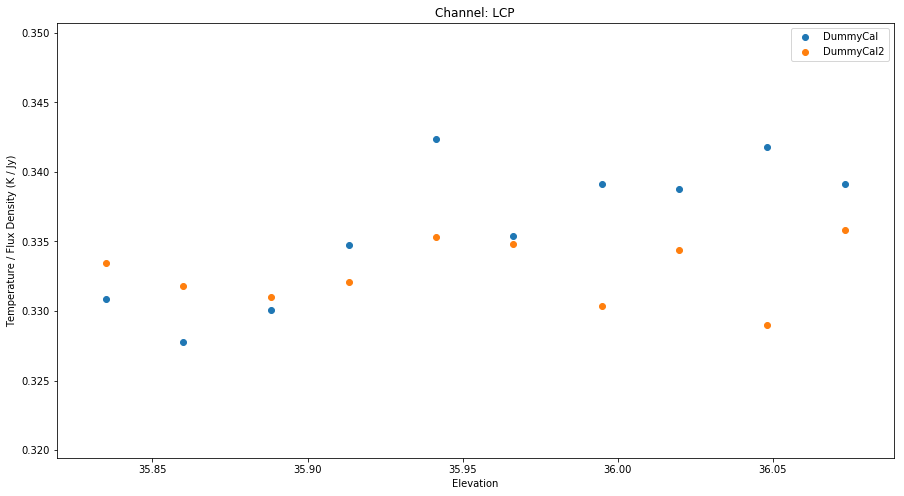

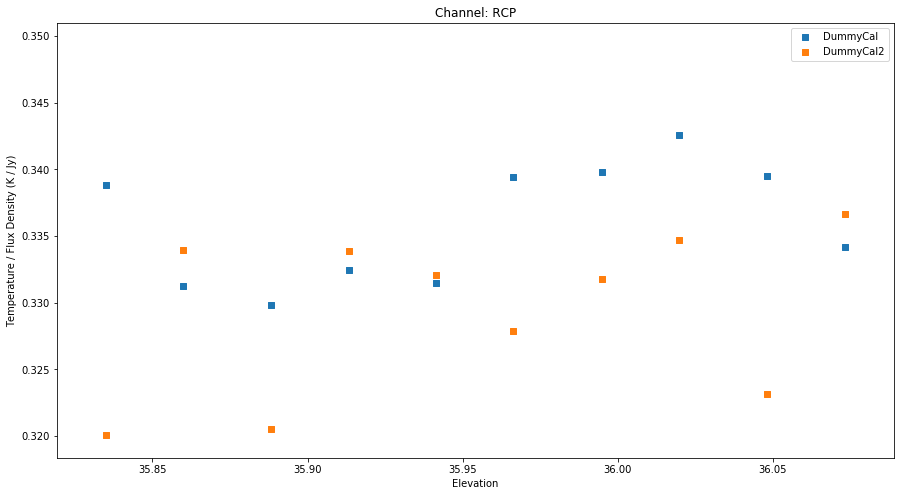

In [14]:
plt.figure(figsize=(15, 8))
good = (table['Source'] == 'DummyCal')&(table['Chan'] == 'Feed0_LCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal', marker='o')
good = (table['Source'] == 'DummyCal2')&(table['Chan'] == 'Feed0_LCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal2', marker='o')

plt.title('Channel: LCP')
plt.xlabel('Elevation')
plt.ylabel('Temperature / Flux Density (K / Jy)')
plt.legend()

plt.figure(figsize=(15, 8))
good = (table['Source'] == 'DummyCal')&(table['Chan'] == 'Feed0_RCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal', marker='s')
good = (table['Source'] == 'DummyCal2')&(table['Chan'] == 'Feed0_RCP')
plt.scatter(table['Elevation'][good], table['Flux/T'][good],
            label='DummyCal2', marker='s')

plt.title('Channel: RCP')
plt.xlabel('Elevation')
plt.ylabel('Temperature / Flux Density (K / Jy)')
plt.legend()


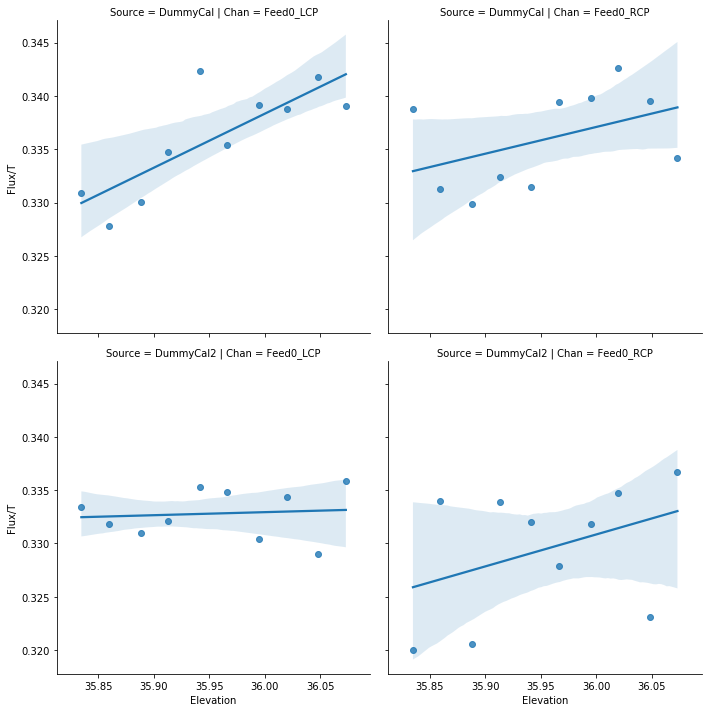

In [15]:
fig = plt.figure(figsize=(15., 8))
g = lmplot(x="Elevation", y="Flux/T", row='Source', col='Chan',
           truncate=True, size=5, data=table)

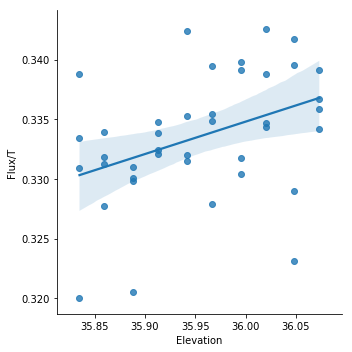

In [16]:
fig = plt.figure(figsize=(15., 8))
g = lmplot(x="Elevation", y="Flux/T",
           truncate=True, data=table)

But we can do everything we want with that information... For example a pairplot

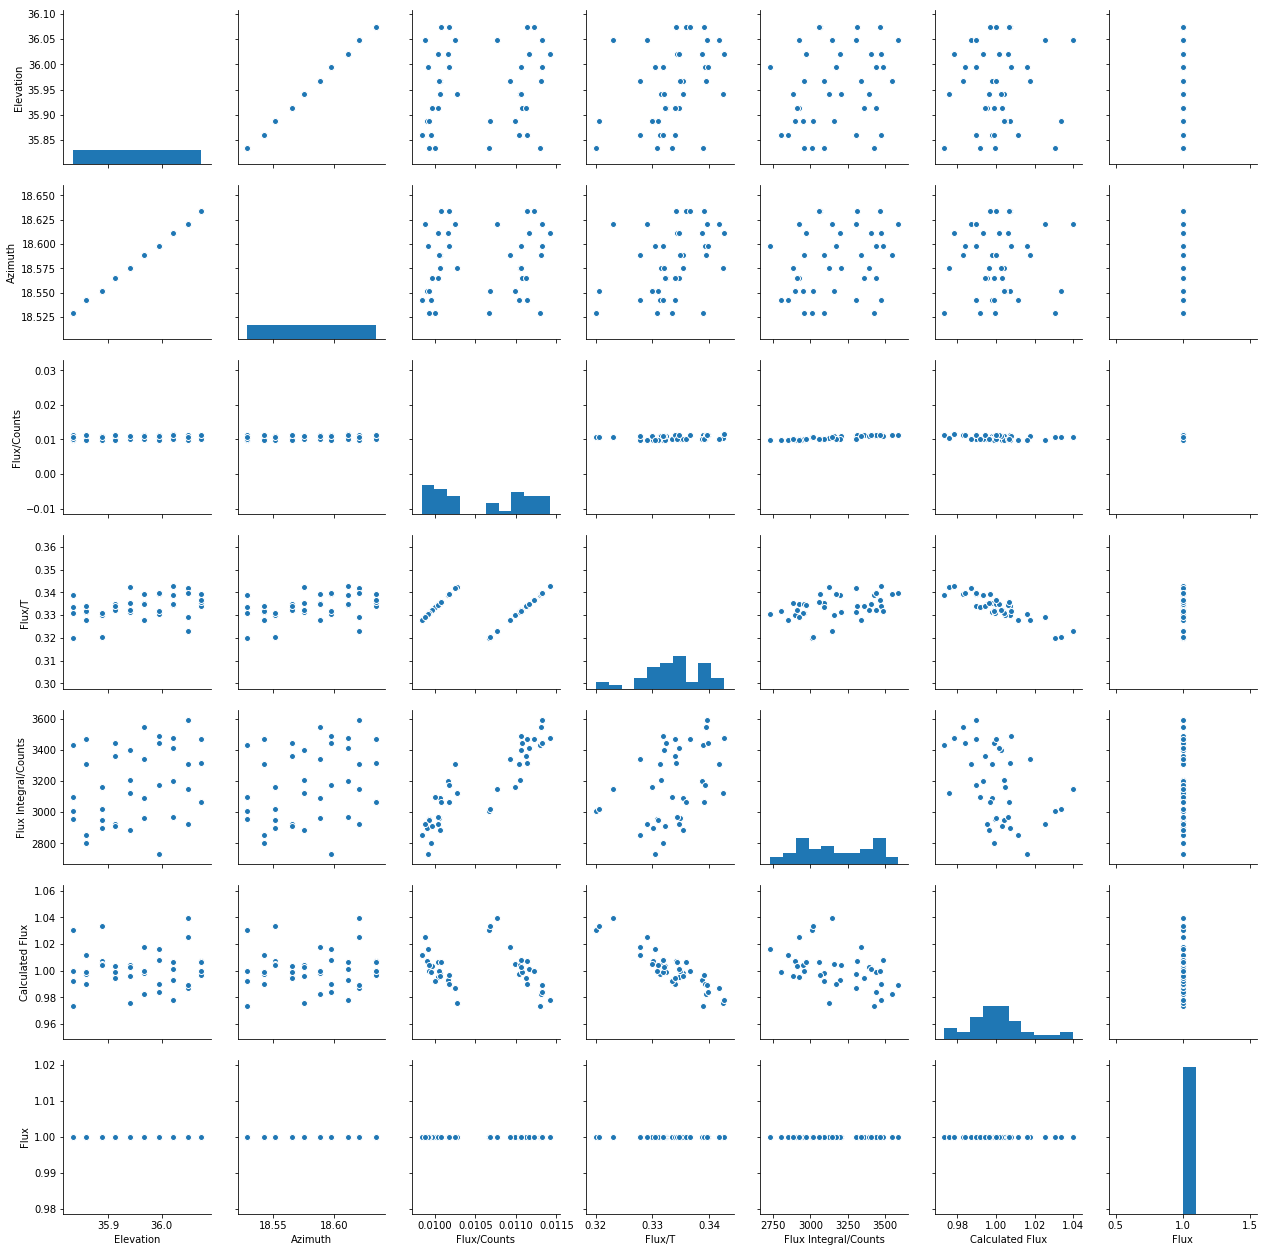

In [17]:
pairplot(table, vars=['Elevation', 'Azimuth', 'Flux/Counts', 'Flux/T', 'Flux Integral/Counts', 'Calculated Flux', 'Flux'])

In [18]:
table

,Dir,File,Scan Type,Source,Chan,Feed,Time,Frequency,Bandwidth,Counts,...,Calculated Flux Err,RA,Dec,Fit RA,Fit Dec,RA err,Dec err,Skewness,Kurtosis,Flux/T
0,/Users/meo/devel/spyder_projects/SRT/srt-singl...,0_Dec.fits,Dec>,DummyCal,Feed0_LCP,0,57000.000445,6900.0,680.0,101.698142,...,0.003919,185.0,75.0,NaN,75.000316,NaN,0.000316,NaN,-302.797297,0.327767
1,/Users/meo/devel/spyder_projects/SRT/srt-singl...,0_Dec.fits,Dec>,DummyCal,Feed0_RCP,0,57000.000445,6900.0,680.0,90.562382,...,0.003080,185.0,75.0,NaN,75.000315,NaN,0.000315,-1.515503,18.060835,0.331263
2,/Users/meo/devel/spyder_projects/SRT/srt-singl...,0_Ra.fits,RA>,DummyCal,Feed0_LCP,0,57000.000144,6900.0,680.0,100.740628,...,0.002861,185.0,75.0,185.000245,NaN,0.000245,NaN,-1.039798,-11.406534,0.330882
3,/Users/meo/devel/spyder_projects/SRT/srt-singl...,0_Ra.fits,RA>,DummyCal,Feed0_RCP,0,57000.000144,6900.0,680.0,88.540888,...,0.003382,185.0,75.0,185.003771,NaN,0.003771,NaN,-1.765636,24.154794,0.338826
4,/Users/meo/devel/spyder_projects/SRT/srt-singl...,1_Dec.fits,Dec<,DummyCal,Feed0_LCP,0,57000.001046,6900.0,680.0,99.578511,...,0.003653,185.0,75.0,NaN,74.998397,NaN,-0.001603,NaN,-656.371494,0.334744
5,/Users/meo/devel/spyder_projects/SRT/srt-singl...,1_Dec.fits,Dec<,DummyCal,Feed0_RCP,0,57000.001046,6900.0,680.0,90.240851,...,0.004058,185.0,75.0,NaN,74.998985,NaN,-0.001015,41.064269,-358.736662,0.332443
6,/Users/meo/devel/spyder_projects/SRT/srt-singl...,1_Ra.fits,RA<,DummyCal,Feed0_LCP,0,57000.000745,6900.0,680.0,100.996299,...,0.003963,185.0,75.0,184.996211,NaN,-0.003789,NaN,NaN,-346.635364,0.330047
7,/Users/meo/devel/spyder_projects/SRT/srt-singl...,1_Ra.fits,RA<,DummyCal,Feed0_RCP,0,57000.000745,6900.0,680.0,90.955710,...,0.003273,185.0,75.0,184.994480,NaN,-0.005520,NaN,16.071160,-121.337685,0.329831
8,/Users/meo/devel/spyder_projects/SRT/srt-singl...,2_Dec.fits,Dec>,DummyCal,Feed0_LCP,0,57000.001647,6900.0,680.0,99.378056,...,0.003321,185.0,75.0,NaN,75.000312,NaN,0.000312,-1.225996,20.031737,0.335404
9,/Users/meo/devel/spyder_projects/SRT/srt-singl...,2_Dec.fits,Dec>,DummyCal,Feed0_RCP,0,57000.001647,6900.0,680.0,88.377983,...,0.002871,185.0,75.0,NaN,74.999866,NaN,-0.000134,-3.071445,-7.038698,0.339451


# Create map

This is done with `SDTimage`. WCS coordinates are automatically calculated and results are written into a `ds9`- and `casaviewer`-compatible FITS file.

To visualize, I'm using the `astropy` library here.

The `-e <regionfile>` tells the baseline subtraction algorithm to ignore a given part of the map where strong sources are present. This region file has to be in DS9 format and *contain coordinates in the fk5 reference frame*. E.g.

In [19]:
!cat center.reg

# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
circle(12:00:00.000,+70:00:00.00,600")


As usual, please ignore below the warnings about outliers. This meanse that the baseline subtraction algorithm is ignoring some points from the fit.

In [20]:
!SDTimage -c CCB_TP_Dummy_Obs0.ini --sub --refilt -e center.reg

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttool

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1067-py3.6.egg/srttools/fit.py:304: UserWarning: Found 2 outliers
  UserWarning)
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev106

Image max is 1982.078958262568
Image sum is 159945.89269356267
Image median is 0.028074927707476653


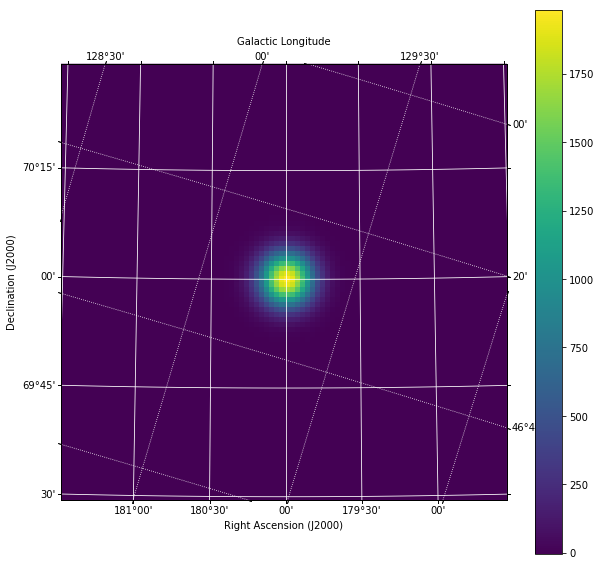

In [21]:
def plot_image(file, ext, logstretch=False):
    hdu = fits.open(file)[ext]
    wcs = WCS(hdu.header)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)
    img = hdu.data
    if logstretch:
        # Create an ImageNormalize object
        norm = ImageNormalize(img, interval=MinMaxInterval(),
                              stretch=LogStretch())
        im = ax.imshow(img, origin='lower', cmap='viridis', norm=norm)
    else:
        im = ax.imshow(img, origin='lower', cmap='viridis')
        
    print("Image max is", np.max(img))
    print("Image sum is", np.sum(img))
    print("Image median is", np.median(img))

    ax.coords.grid(True, color='white', ls='solid')
    ax.coords[0].set_axislabel('Right Ascension (J2000)')
    ax.coords[1].set_axislabel('Declination (J2000)')

    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='white', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude')
    overlay[1].set_axislabel('Galactic Latitude')
    plt.colorbar(im)

plot_image('CCB_TP_Dummy_Obs0.fits', 1)

Image max is 1982.078958262568
Image sum is 159945.89269356267
Image median is 0.028074927707476653


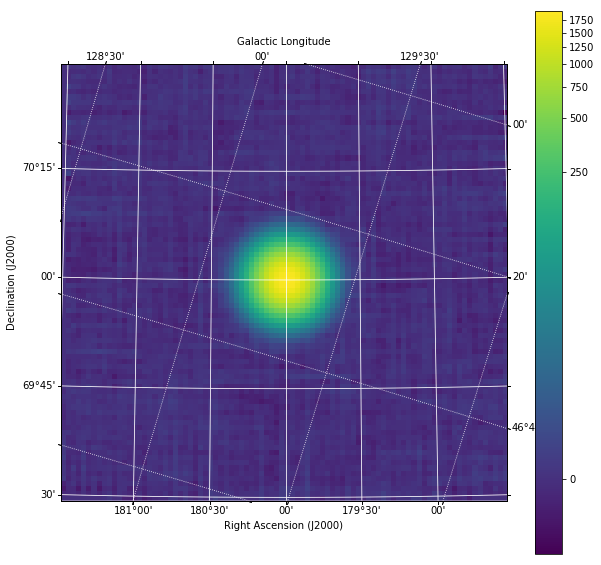

In [22]:
plot_image('CCB_TP_Dummy_Obs0.fits', 1, logstretch=True)

The log-stretched image shows that the noisy scans can create stripes in the map. There are a couple of different ways to deal with this in SDT. One is interactive and the other is automatic. Let us now use the...

# Interactive filtering

We can cleanup the scans interactively. A window opens and we can point and click to select all scans passing through a pixel, and flag bad scans, zap intervals, redo baseline fitting, etc.

Please follow the instructions that appear in the shell. For example, to select all scans passing through a given pixel and +- 1 pixel around, point the pixel with the mouse and press "a". 
A new window will open showing all the scans. Click on a scan (it becomes green), and filter out intervals in the scan, fit a new baseline, flag scans, etc. by following the instructions appearing in the shell.

In [19]:
!SDTimage -c CCB_TP_Dummy_Obs0.ini --interactive

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
402/402
        -------------------------------------------------------------

        Imageactive display.

        You see here two images. The left one gives, for each bin, a number
        measuring the probability of outliers (based on the median absolute
        deviation if there are >10 scans per bin, and on the standard deviation
        otherwise), The right one is the output image of the p

# Calibrate the image

Now we can calibrate the image, using the calibration calculated above, using the option `--calibrate <CALFILE>.hdf5` and specifying the unit (Jy/beam, Jy/pixel, or Jy/sterad) with `-u <UNIT>` 

Note: instead of the calibration file, we can give the HDF5 file dumped by `SDTimage` in the previous processing.
Instead of `SDTimage -c CCB_TP_Dummy_Obs0.ini`, we could use `SDTimage CCB_TP_Dummy_Obs0_dump.hdf5`

In [23]:
!SDTimage -c CCB_TP_Dummy_Obs0.ini -u 'Jy/pixel' --calibrate CCB_TP_Dummy_Obs0_cal.hdf5

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Image max is 0.2247480332018821
Image sum is 18.12869310148658
Image median is 3.202302772118162e-06


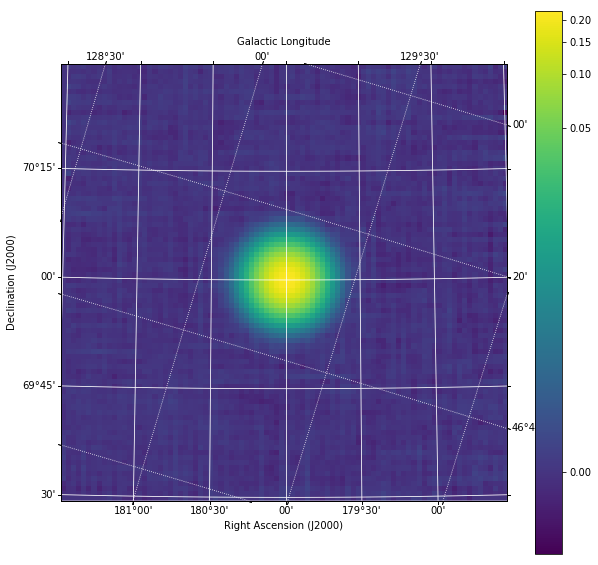

In [24]:
plot_image('CCB_TP_Dummy_Obs0_cal.fits', 1, logstretch=True)

# Destriping

After the most problematic scans have been eliminated, we can use a new algorithm to "destripe" the image.
This algorithm is known as "basket weaving", because it's a little bit like making coincide stripes orthogonal to each other. To use this algorithm, we use the option --destripe

In [36]:
!SDTimage CCB_TP_Dummy_Obs0_dump.hdf5 -u 'Jy/beam' --calibrate CCB_TP_Dummy_Obs0_cal.hdf5 --destripe

/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/meo/anaconda/envs/py3/lib/python3.6/site-packages/srttools-0.5.dev1069-py3.6.egg/srttools/destripe.py:159: RuntimeWarning: invalid value encountered in true_divide
  (image_hor*expo_hor + image_ver*expo_ver) / (expo_hor + expo_ver)


Image max is 19.266596090571003
Image sum is 1554.8390897968554
Image median is 0.00017813541981552756


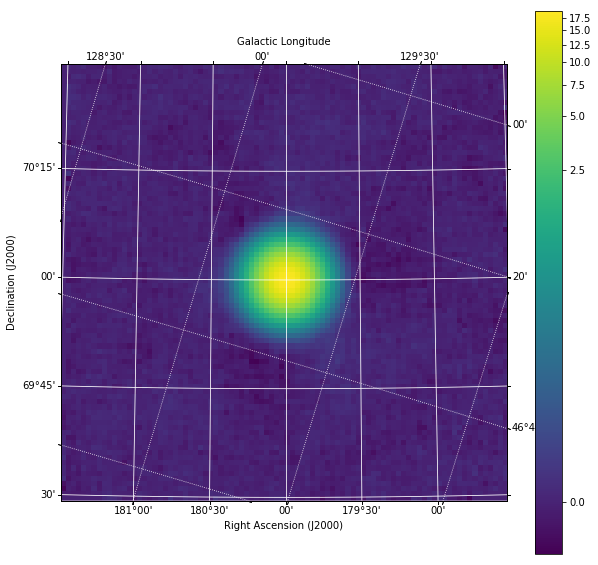

In [37]:
plot_image('CCB_TP_Dummy_Obs0_cal_destripe.fits', 1, logstretch=True)